# Experiment 5: Equilibrium Selection in Coordination Games

**Objective**: Compare all 4 CFR variants on the "Equilibrium Selection" problem (or "Tower of Babel" problem) highlighted in the Pluribus paper.

**Context**: In multiplayer general-sum games, there can be multiple Nash Equilibria. If Agent A plays Strategy 1 (part of Equilibrium 1) and Agent B plays Strategy 2 (part of Equilibrium 2), their joint play might be disastrous, even if both strategies are individually "rational" in their respective contexts.

**Algorithms Compared**:
1. **MCCFR (Vanilla)** - Monte Carlo sampling at chance nodes
2. **MCCFR+** - Monte Carlo with regret flooring + linear averaging
3. **Full-Width CFR (Vanilla)** - Textbook algorithm, full expectation at chance nodes
4. **Full-Width CFR+** - Textbook CFR+ with regret flooring + linear averaging

**The Game**: A 3-Player "Pure Coordination" game.
*   **Players**: 3
*   **Actions**: 3 (A, B, C)
*   **Payoff**: +1 to everyone if all players choose the SAME action. 0 otherwise.
*   **Equilibria**: (A,A,A), (B,B,B), (C,C,C) are all pure Nash Equilibria.

**Experiment**: Do different CFR variants converge to different equilibria? Do some fail to coordinate?

In [1]:
%matplotlib inline
import pyspiel
import numpy as np
import matplotlib.pyplot as plt
from solvers import CFRSolver, CFRPlusSolver, FullWidthCFRSolver, FullWidthCFRPlusSolver
from open_spiel.python.algorithms import exploitability

print("Setting up Coordination Game...")

# Define Payoff Tensor for 3-Player Coordination Game
# Shape: (3, 3, 3) for 3 actions each
payoffs = np.zeros((3, 3, 3))

# Set diagonal to 1 (Coordination Success)
for i in range(3):
    payoffs[i, i, i] = 1.0

# Create Tensor Game
tensor_game = pyspiel.create_tensor_game([payoffs, payoffs, payoffs])
game = pyspiel.convert_to_turn_based(tensor_game)

print("Game created. Payoffs are 1.0 if all match, 0.0 otherwise.")

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
Setting up Coordination Game...
Game created. Payoffs are 1.0 if all match, 0.0 otherwise.


Training MCCFR (Vanilla)...
Iteration 1000/5000 - NashConv: 0.002312
Iteration 2000/5000 - NashConv: 0.001157
Iteration 3000/5000 - NashConv: 0.000771
Iteration 4000/5000 - NashConv: 0.000579
Iteration 5000/5000 - NashConv: 0.000463
Training MCCFR+...
Iteration 1000/5000 - NashConv: 0.000851
Iteration 2000/5000 - NashConv: 0.000213
Iteration 3000/5000 - NashConv: 0.000095
Iteration 4000/5000 - NashConv: 0.000053
Iteration 5000/5000 - NashConv: 0.000034
Training Full-Width CFR (Vanilla)...
Iteration 1000/5000 - NashConv: 0.002312
Iteration 2000/5000 - NashConv: 0.001157
Iteration 3000/5000 - NashConv: 0.000771
Iteration 4000/5000 - NashConv: 0.000579
Iteration 5000/5000 - NashConv: 0.000463
Training Full-Width CFR+...
Iteration 1000/5000 - NashConv: 0.000851
Iteration 2000/5000 - NashConv: 0.000213
Iteration 3000/5000 - NashConv: 0.000095
Iteration 4000/5000 - NashConv: 0.000053
Iteration 5000/5000 - NashConv: 0.000034

Evaluating coordination rates...


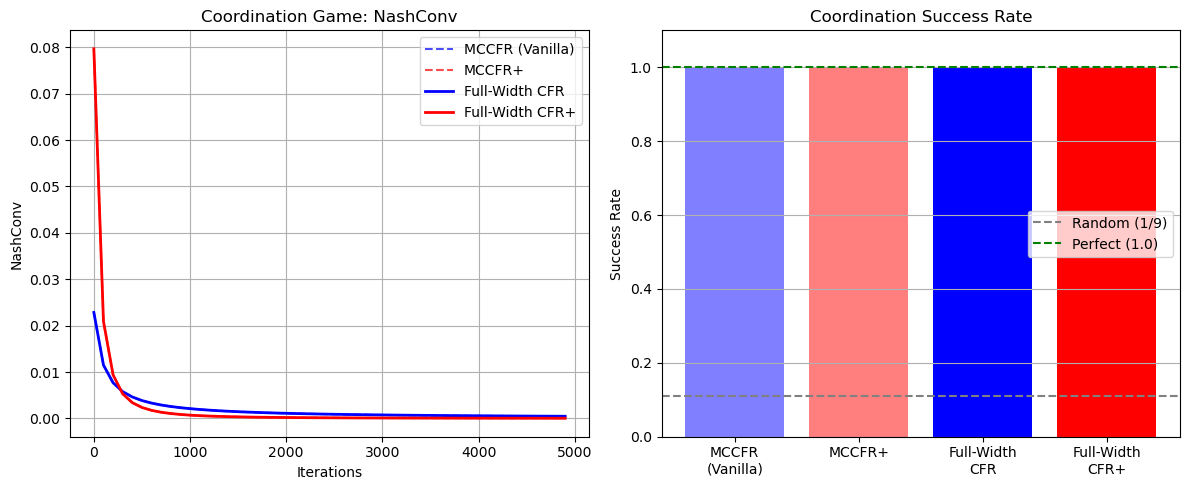


=== Coordination Game Results ===
Algorithm                 Final NashConv     Coordination Rate 
-----------------------------------------------------------------
MCCFR (Vanilla)           0.000463           99.90%            
MCCFR+                    0.000034           100.00%           
Full-Width CFR            0.000463           100.00%           
Full-Width CFR+           0.000034           100.00%           

Random baseline: 11.11% (if all play uniform 1/3 each)


In [2]:
# Train all 4 solvers and compare
iterations = 5000
log_every = 100

def evaluate_coordination_rate(policy, game, num_evals=1000):
    """Evaluate how often players successfully coordinate."""
    success_count = 0
    for _ in range(num_evals):
        state = game.new_initial_state()
        actions_taken = []
        while not state.is_terminal():
            probs = policy.action_probabilities(state)
            action = np.random.choice(list(probs.keys()), p=list(probs.values()))
            actions_taken.append(action)
            state.apply_action(action)
        if len(set(actions_taken)) == 1:
            success_count += 1
    return success_count / num_evals

# Train all 4 solvers
print("Training MCCFR (Vanilla)...")
solver_mc_vanilla = CFRSolver(game)
history_mc_vanilla = solver_mc_vanilla.train(iterations, log_every=log_every)

print("Training MCCFR+...")
solver_mc_plus = CFRPlusSolver(game)
history_mc_plus = solver_mc_plus.train(iterations, log_every=log_every)

print("Training Full-Width CFR (Vanilla)...")
solver_fw_vanilla = FullWidthCFRSolver(game)
history_fw_vanilla = solver_fw_vanilla.train(iterations, log_every=log_every)

print("Training Full-Width CFR+...")
solver_fw_plus = FullWidthCFRPlusSolver(game)
history_fw_plus = solver_fw_plus.train(iterations, log_every=log_every)

# Plot NashConv comparison
x_axis = np.arange(len(history_mc_vanilla['nash_conv'])) * log_every

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_axis, history_mc_vanilla['nash_conv'], 'b--', label="MCCFR (Vanilla)", alpha=0.7)
plt.plot(x_axis, history_mc_plus['nash_conv'], 'r--', label="MCCFR+", alpha=0.7)
plt.plot(x_axis, history_fw_vanilla['nash_conv'], 'b-', label="Full-Width CFR", linewidth=2)
plt.plot(x_axis, history_fw_plus['nash_conv'], 'r-', label="Full-Width CFR+", linewidth=2)
plt.title("Coordination Game: NashConv")
plt.xlabel("Iterations")
plt.ylabel("NashConv")
plt.legend()
plt.grid(True)

# Evaluate coordination rates
print("\nEvaluating coordination rates...")
coord_mc_vanilla = evaluate_coordination_rate(solver_mc_vanilla.get_policy(), game)
coord_mc_plus = evaluate_coordination_rate(solver_mc_plus.get_policy(), game)
coord_fw_vanilla = evaluate_coordination_rate(solver_fw_vanilla.get_policy(), game)
coord_fw_plus = evaluate_coordination_rate(solver_fw_plus.get_policy(), game)

plt.subplot(1, 2, 2)
algorithms = ['MCCFR\n(Vanilla)', 'MCCFR+', 'Full-Width\nCFR', 'Full-Width\nCFR+']
coord_rates = [coord_mc_vanilla, coord_mc_plus, coord_fw_vanilla, coord_fw_plus]
colors = ['blue', 'red', 'blue', 'red']
alphas = [0.5, 0.5, 1.0, 1.0]

# Create bars individually to support per-bar alpha values
for i, (alg, rate, color, alpha) in enumerate(zip(algorithms, coord_rates, colors, alphas)):
    plt.bar(i, rate, color=color, alpha=alpha)
plt.xticks(range(len(algorithms)), algorithms)
plt.axhline(y=1/9, color='gray', linestyle='--', label="Random (1/9)")
plt.axhline(y=1.0, color='green', linestyle='--', label="Perfect (1.0)")
plt.title("Coordination Success Rate")
plt.ylabel("Success Rate")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\n=== Coordination Game Results ===")
print(f"{'Algorithm':<25} {'Final NashConv':<18} {'Coordination Rate':<18}")
print("-" * 65)
print(f"{'MCCFR (Vanilla)':<25} {history_mc_vanilla['nash_conv'][-1]:<18.6f} {coord_mc_vanilla:<18.2%}")
print(f"{'MCCFR+':<25} {history_mc_plus['nash_conv'][-1]:<18.6f} {coord_mc_plus:<18.2%}")
print(f"{'Full-Width CFR':<25} {history_fw_vanilla['nash_conv'][-1]:<18.6f} {coord_fw_vanilla:<18.2%}")
print(f"{'Full-Width CFR+':<25} {history_fw_plus['nash_conv'][-1]:<18.6f} {coord_fw_plus:<18.2%}")
print(f"\nRandom baseline: {1/9:.2%} (if all play uniform 1/3 each)")

## Result Interpretation

### Key Questions:
1. **Do all algorithms converge to the same NashConv?** In a coordination game with multiple equilibria, low NashConv doesn't guarantee coordination - it could mean converging to a mixed strategy.

2. **Coordination Rate**: This is the key metric here.
   - **~11% (1/9)**: Algorithms converged to uniform mixed strategy (no learning)
   - **~33% (1/3)**: Partial coordination (e.g., all play same action 1/3 of the time)
   - **100%**: Perfect coordination (all converged to same pure equilibrium)

3. **Do different variants behave differently?**
   - Does CFR+ help or hurt coordination?
   - Does full-width vs Monte Carlo matter for equilibrium selection?

### Implications:
- If coordination rate is low, it demonstrates the "equilibrium selection problem"
- CFR minimizes regret but doesn't solve coordination
- This is why Pluribus needed additional mechanisms beyond just CFR